In [1]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray'):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    plt.show()

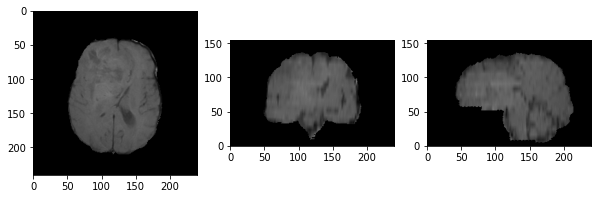

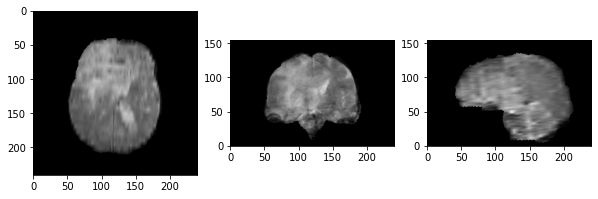

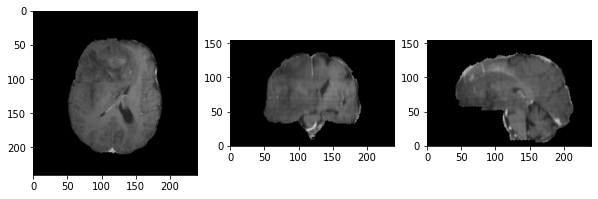

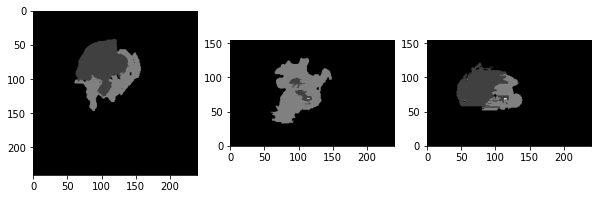

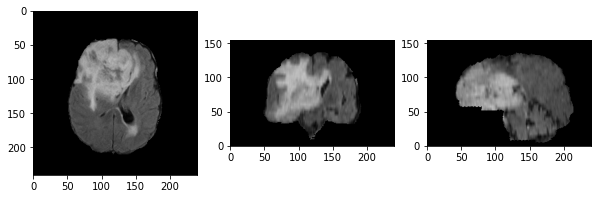

(240, 240, 155)
(1.0, 1.0, 1.0)


In [3]:
# Brats data path
data_dir_name = '/vol/bitbucket/sc5316/Brats17TrainingData/LGG/'
samples = os.listdir(data_dir_name)

# Image
image_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t1.nii.gz'
img = sitk.ReadImage(image_filename)

image2_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t2.nii.gz'
img2 = sitk.ReadImage(image2_filename)

image3_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t1ce.nii.gz'
img3 = sitk.ReadImage(image3_filename)

image4_filename = data_dir_name + samples[3] + '/' + samples[3] + '_seg.nii.gz'
img4 = sitk.ReadImage(image4_filename)

image5_filename = data_dir_name + samples[3] + '/' + samples[3] + '_flair.nii.gz'
img5 = sitk.ReadImage(image5_filename)

display_image(img)
display_image(img2)
display_image(img3)
display_image(img4)
display_image(img5)

print(img4.GetSize())
print(img4.GetSpacing())

In [4]:
def zero_mean_unit_var(image):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    mean = np.mean(img_array[img_array>0])
    std = np.std(img_array[img_array>0])

    if std > 0:
        img_array = (img_array - mean) / std

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing), -1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    def __init__(self, file_list_img, file_list_seg, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            #normalisation
            img = zero_mean_unit_var(img)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)

        return {'img': image, 'seg': seg}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device: ' + str(device))
print(torch.__version__)

NameError: name 'torch' is not defined

In [6]:
rnd_seed = 42

img_size = [120, 120, 120]
img_spacing = [2.0, 2.0, 2.0]

num_epochs = 150
learning_rate = 0.01
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [7]:
files_seg_img = [data_dir_name + s + '/' + s + '_flair.nii.gz' for s in samples]
files_seg_seg = [data_dir_name + s + '/' + s + '_seg.nii.gz' for s in samples]

# Load training data
dataset_train = ImageSegmentationDataset(files_seg_img[:2], files_seg_seg[:2], img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

dataset_val = ImageSegmentationDataset(files_seg_img[55:57], files_seg_seg[55:57], img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

# dataset_test = ImageSegmentationDataset(files_seg_img[65:], files_seg_seg[65:], img_spacing, img_size)
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Image: Brats17_TCIA_202_1_flair.nii.gz


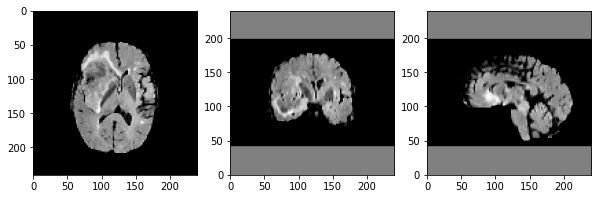

Segmentation


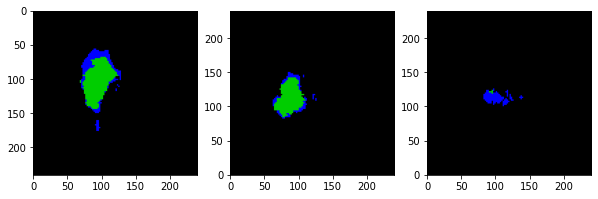

(120, 120, 120)


In [8]:
sample = dataset_val.get_sample(0)
img_name = dataset_val.get_img_name(0)
seg_name = dataset_val.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print(sample['img'].GetSize())

In [11]:
# class UnetDown(nn.Module):

#     def __init__(self, in_channels,out_channels):
#         super(UnetDown, self).__init__()
#         self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3,padding=1)
#         self.batch_norm = nn.BatchNorm3d(out_channels)
#         self.pool  = nn.MaxPool3d(2)
#         # TODO: Add dropout
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(self.batch_norm(x))
#         x_downsample = self.pool(x)
#         return x, x_downsample


# class UnetUp(nn.Module):

#     def __init__(self, in_channels):
#         super(UnetUp, self).__init__()
#         self.upconv = nn.ConvTranspose3d(in_channels, in_channels, kernel_size=2, stride=2)
#         self.conv1 = nn.Conv3d(2 * in_channels, int(in_channels / 2), kernel_size=3,padding=1)
#         self.batch_norm = nn.BatchNorm3d(int(in_channels/2))
  
#     def forward(self, x_up, x_down):
#         x_up = self.upconv(x_up)
#         concat_fm = torch.cat((x_up, x_down), 1)
#         x = self.conv1(concat_fm)
#         x = F.relu(self.batch_norm(x))
#         return x

# class Unet(nn.Module):
  
#     def __init__(self,in_channels, out_channels, num_classes):
#         super(Unet,self).__init__()
#         self.encode1 = UnetDown(in_channels, out_channels)
#         self.encode2 = UnetDown(out_channels, 2 * out_channels)
#         self.conv1 = nn.Conv3d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1)
#         self.decode1 = UnetUp(2 * out_channels)
#         self.decode2 = UnetUp(out_channels)
#         self.out_conv = nn.Conv3d(int(out_channels/2),num_classes,kernel_size=3)


#     def forward(self, x):
#         enc1 = self.encode1(x)
#         enc2 = self.encode2(enc1[1])
#         x1 = self.conv1(enc2[1])
#         dec1 = self.decode1(x1,enc2[0])
#         dec2 = self.decode2(dec1,enc1[0])
#         x_out = self.out_conv(dec2)
#         x_out = F.softmax(dec2, dim=1)
#         return x_out

In [10]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels, is_first_layer=False):
        super(UnetDown, self).__init__()
        layers = []
        
        if not is_first_layer:
            layers.append(nn.MaxPool3d(2))
        else:
            layers.extend([
                nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout3d(p=0.5)
            ])
        
        self.encode = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.encode(x)

    
    
class UnetCentre(nn.Module):
    def __init__(self, in_channels, out_channels, deconv_channels):
        super(UnetCentre, self).__init__()
        layers = [
            nn.MaxPool3d(2),
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(out_channels, deconv_channels, kernel_size=2, stride=2),
            nn.Dropout3d(p=0.5)
        ]
        
        self.centre = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.centre(x)
    


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, deconv_channels, is_last_layer=False):
        super(UnetUp, self).__init__()
        layers = [
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
        if is_last_layer:
            layers.extend([
                nn.Conv3d(out_channels, deconv_channels, kernel_size=1),
                nn.Softmax(dim=1)
            ])
        else:
            layers.extend([
                nn.ConvTranspose3d(out_channels, deconv_channels, kernel_size=2, stride=2),
                nn.Dropout3d(p=0.5)
            ])
        
        self.decode = nn.Sequential(*layers)
  
    def forward(self, x):
        return self.decode(x)

    
    
class Unet(nn.Module):
    def __init__(self,in_channels, out_channels, conv_depths=(32, 64)):
#     def __init__(self,in_channels, out_channels, conv_depths=(64, 128, 256, 512, 1024)):
        super(Unet,self).__init__()
        encode_layers = [UnetDown(in_channels, conv_depths[0], is_first_layer=True)]
        encode_layers.extend(
            [UnetDown(conv_depths[i], conv_depths[i + 1]) for i in range(len(conv_depths)-2)])
        decode_layers = [UnetUp(2*conv_depths[i+1], 2*conv_depths[i], conv_depths[i]) for i in reversed(range(len(conv_depths)-2))]
        decode_layers.append(UnetUp(conv_depths[1], conv_depths[0], out_channels, is_last_layer=True))
        
        self.encode_layers = nn.Sequential(*encode_layers)
        self.centre_layer = UnetCentre(conv_depths[-2], conv_depths[-1], conv_depths[-2])
        self.decode_layers = nn.Sequential(*decode_layers)

    def forward(self, x, return_all=False):
        x_enc = [x]
        for enc_layer in self.encode_layers:
            x_enc.append(enc_layer(x_enc[-1]))

        x_dec = [self.centre_layer(x_enc[-1])]
        for dec_layer_idx, dec_layer in enumerate(self.decode_layers):
            x_opposite = x_enc[-1-dec_layer_idx]
#             x_cat = torch.cat(
#                 [pad_to_shape(x_dec[-1], x_opposite.shape), x_opposite],
#                 dim=1
#             )
            x_cat = torch.cat((x_dec[-1], x_opposite), dim=1)
            x_dec.append(dec_layer(x_cat))

        if not return_all:
            return x_dec[-1]
        else:
            return x_enc + x_dec
        
def pad_to_shape(this, shp):
    if len(shp) == 4:
        pad = (0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
        print(shp[3])
        print(shp[2])
        print(this.shape[3])
        print(this.shape[2])
    elif len(shp) == 5:
        pad = (0, shp[4] - this.shape[4], 0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    return F.pad(this, pad)

In [11]:
torch.cuda.empty_cache()

model_dir = os.path.join(out_dir, 'segmentation_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = Unet(1,3)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

model.to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        print(img.size())
        optimizer.zero_grad()
        prd = model(img)
        print(prd.size())
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        del img
        del seg
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))

torch.save(model.state_dict(), os.path.join(model_dir, 'model2.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Let's use 6 GPUs!
START TRAINING...
torch.Size([2, 1, 120, 120, 120])


RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-10-ef0bad3764d6>", line 105, in forward
    x_dec.append(dec_layer(x_cat))
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-10-ef0bad3764d6>", line 74, in forward
    return self.decode(x)
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py", line 100, in forward
    input = module(input)
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/modules/batchnorm.py", line 107, in forward
    exponential_average_factor, self.eps)
  File "/vol/bitbucket/sc5316/pythonMed/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py", line 1670, in batch_norm
    training, momentum, eps, torch.backends.cudnn.enabled
RuntimeError: CUDA out of memory. Tried to allocate 212.00 MiB (GPU 1; 11.17 GiB total capacity; 2.56 GiB already allocated; 79.94 MiB free; 2.59 GiB reserved in total by PyTorch)


In [18]:
def get_dice_scores(gt, pred, label):
    
    gt = sitk.GetArrayFromImage(gt)
    pred = sitk.GetArrayFromImage(pred)    
    
    gt = gt.flatten()
    pred = pred.flatten()
    TP = len(np.where((gt==label) & (pred==label))[0])
    FP = len(np.where((gt!=label) & (pred==label))[0])
    FN = len(np.where((gt==label) & (pred!=label))[0])

    return 2 * TP / ((2 * TP) + FP + FN)

In [13]:
model_dir = os.path.join(out_dir, 'segmentation_model')
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = Unet(1,32,4).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model2.pt')))
model.to(device)
model.eval()
    
csf_dice_scores = []
gm_dice_scores  = []


print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        
        csf_dice_scores.append(get_dice_scores(sample['seg'], prediction, 1))
        gm_dice_scores.append(get_dice_scores(sample['seg'], prediction, 2))
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

TypeError: 'int' object is not subscriptable

{'whiskers': [<matplotlib.lines.Line2D at 0x7feb3bfd4610>,
 'caps': [<matplotlib.lines.Line2D at 0x7feb3c714490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feb3bfd48d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb3c735050>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feb3c7353d0>],
 'means': []}

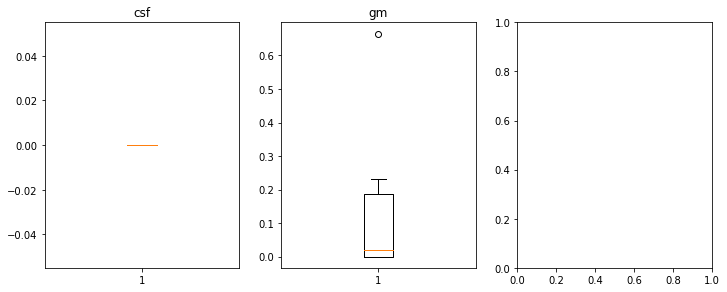

In [22]:
####################TEST##########################
fig, axes = plt.subplots(1,3,figsize=(10,4))
fig.tight_layout()
axes[0].title.set_text('csf')
axes[0].boxplot(csf_dice_scores)
axes[1].title.set_text('gm')
axes[1].boxplot(gm_dice_scores)